## Computational ressources

## Librairies and customization

In [1]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
today=date.today()

import sys
sys.path.insert(0,'/home/albert7a/git/xscale')
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

import matplotlib.pyplot as plt
params = {'figure.figsize' : (15, 8),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
%time ds=xr.open_zarr('/store/albert7a/eNATL60/zarr/eNATL60-BLBT02-SSH-1h')
ds

CPU times: user 114 ms, sys: 50.1 ms, total: 164 ms
Wall time: 222 ms


<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 11688, x: 8354, y: 4729)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(11688,), chunksize=(240,)>
  * time_counter          (time_counter) datetime64[ns] 2010-01-19T00:30:00 ... 2009-09-17T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    nav_lat               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    nav_lon               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    sossheig              (time_counter, y, x) float32 dask.array<shape=(11688, 4729, 8354), chunksize=(240, 240, 480)>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
Attributes:
    Conventions:  CF-1.6
    TimeStamp:    24/03/2019 14:43:2

In [3]:
ds_sorted=ds.sortby('time_counter')

In [4]:
print(ds.nbytes/1e9)

1847.304207184


In [5]:
ssh_FMA=ds_sorted.sel(time_counter=slice('2010-02-01','2010-04-30'))['sossheig']

In [6]:
ssh_ASO=ds_sorted.sel(time_counter=slice('2009-08-01','2009-10-31'))['sossheig']

In [7]:
ssh_FMA_reg=ssh_FMA[:,1995:2005,3995:4005]

In [8]:
ssh_ASO_reg=ssh_ASO[:,1995:2005,3995:4005]

In [9]:
%%time 

NPADDING = 2
SPtime_FMA_reg = xfft.fft(ssh_FMA_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_FMA_reg.shape[0]*NPADDING,tapering=True)
SPtime_ASO_reg = xfft.fft(ssh_ASO_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_ASO_reg.shape[0]*NPADDING,tapering=True)
MEANPSD_FMA=xfft.psd(SPtime_FMA_reg).mean(dim='x').mean(dim='y').load()
MEANPSD_ASO=xfft.psd(SPtime_ASO_reg).mean(dim='x').mean(dim='y').load()
freqs_FMA=MEANPSD_FMA.f_time_counter.values
freqs_FMA = freqs_FMA[NPADDING::] 
freqs_ASO=MEANPSD_ASO.f_time_counter.values
freqs_ASO = freqs_ASO[NPADDING::] 


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


CPU times: user 33.8 s, sys: 2min 4s, total: 2min 38s
Wall time: 8.73 s


Text(0.5, 1.0, 'Temporal Spectrum of SSH in the box')

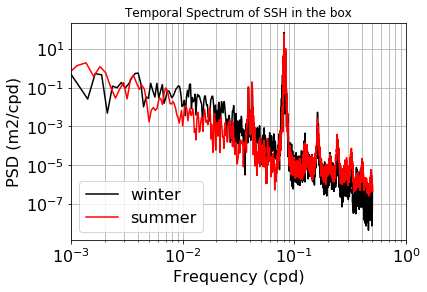

In [10]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cpd)')
plt.ylabel('PSD (m2/cpd)')
plt.legend()
plt.title('Temporal Spectrum of SSH in the box')